#Supervised Learning  

1. Introduction

In this notebook, we will build a model using Tensorflow and Keras to predict age and gender of an individual

Let us mount the drive with data and import the necessary libraries. 

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
!unzip -o /content/drive/MyDrive/DL_Comp263_section2_Gr1/Data/UTKFace/archive.zip -d /content/utkface/
BASE_DIR = "/content/utkface/UTKFace/*"



Streaming output truncated to the last 5000 lines.
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  in

# 2. Load Data

In this section we will build 3 lists by going through all the images in the BASE_DIR-
1. a list of paths of images
2. a list of age labels
3. a list of gender labels where 1 refers to male and 0 refers to male.

In [ ]:

from glob import glob
image_paths = []
age_labels = []
gender_labels = []

for filepath in tqdm(glob(BASE_DIR)):
    filename = filepath.split("/")[-1]
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(filepath)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

We can see that there are 23708 images in the folder. Let us now build a dataframe out of 3 lists and print them. 

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
pd.set_option('display.max_colwidth', -1)
df.head()

,image,age,gender
0,/content/utkface/UTKFace/41_0_0_20170104205956308.jpg.chip.jpg,41,0
1,/content/utkface/UTKFace/55_1_0_20170110160643547.jpg.chip.jpg,55,1
2,/content/utkface/UTKFace/38_1_1_20170117190452524.jpg.chip.jpg,38,1
3,/content/utkface/UTKFace/29_0_1_20170117094430566.jpg.chip.jpg,29,0
4,/content/utkface/UTKFace/38_0_4_20170104174520099.jpg.chip.jpg,38,0


In [ ]:
#df =df[:8000]

Create a dictionary for two lables 

In [ ]:

# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

Print a sample image 

Text(0.5, 1.0, 'The person in picture is 41 years old ')

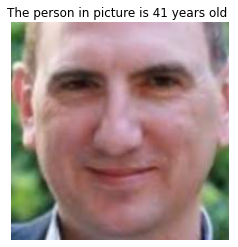

In [ ]:

age=df['age'][0]
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);
plt.title(f"The person in picture is {age} years old ")


# 3. Analyse the Target variables - Age and Gender

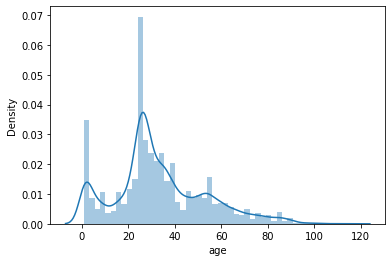

In [ ]:
sns.distplot(df['age'])

From the above plot, we can see that the histogram is right skewed. Some faces are 100 years old. We also have faces of many new-borns. Most of the images belong to age group 0 to 20 years old.

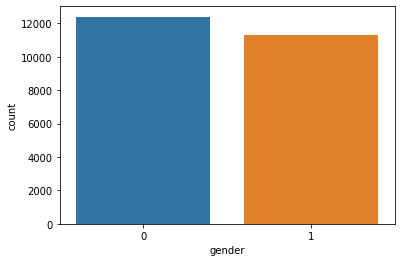

In [ ]:
sns.countplot(df['gender'])

From the above graph, we can see that the dataset is almost balanced. There are sufficient samples belonging to class 0 and class 1

Let us print some images.

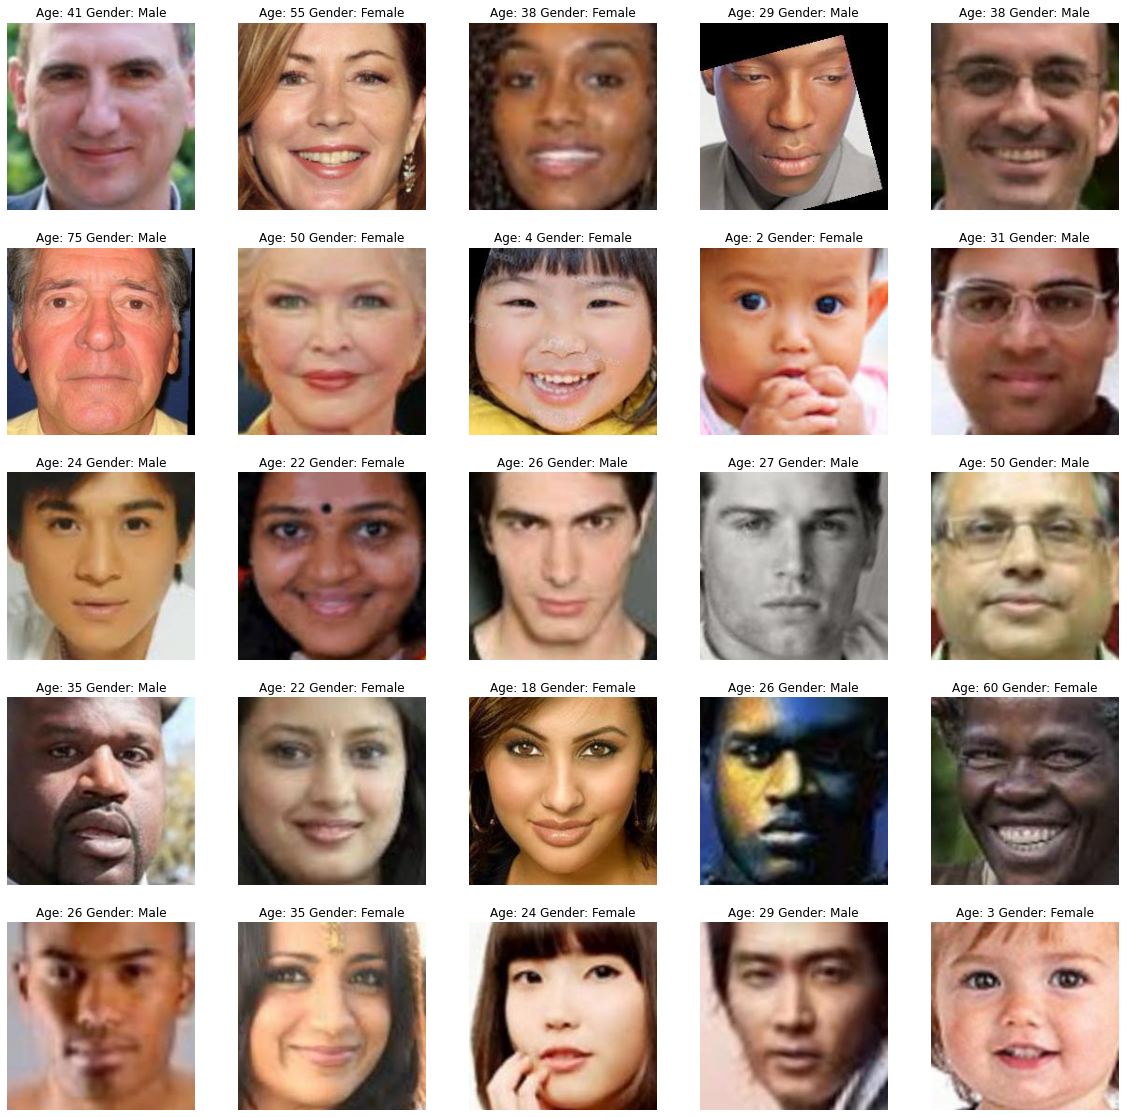

In [ ]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

#4.  Data Preprocessing steps:
1. Convert Images to Grayscale
2. Resize Images to 128x128 Pixels 
3. Normalize Images between 0 and 1


In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)  
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:


X = extract_features(df['image'])



  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# normalize the images
X = X/255.0


In [ ]:
X.shape

(23708, 128, 128, 1)


# 5. Preprare Train and Test Splits

In this section, we will create 2 splits of data Train and Test.

In [ ]:

y=np.array(df[['age','gender']])

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
len(X_train),len(X_test)

(18966, 4742)

In [ ]:
y_train_age=np.array(y_train[:, 0])

In [ ]:
y_train_gender=np.array(y_train[:, 1])

In [ ]:
y_test_age=np.array(y_test[:, 0])

In [ ]:
y_test_gender=np.array(y_test[:, 1])

In [ ]:
len(y_train_age)

18966

In [ ]:
X_train.shape

(18966, 128, 128, 1)

# 6. Create a Deep CNN Model to estimate age and gender.

In [ ]:

input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy','mse'])

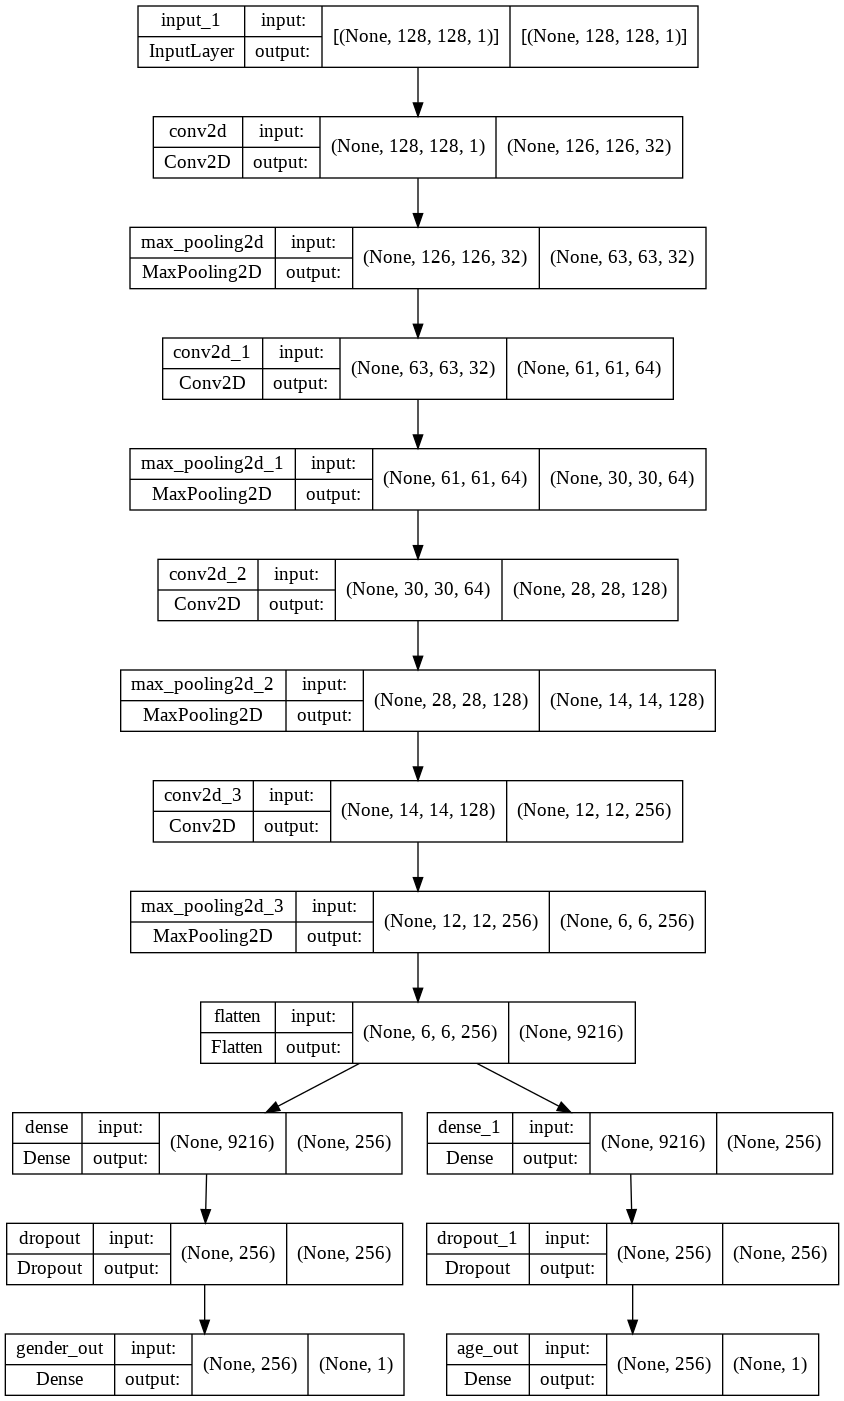

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='sup_model.png', show_shapes=True)

Create a callback to save the best model

In [ ]:
# train model
callbacks= tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/DL_Comp263_section2_Gr1/Code/model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
)

history = model.fit(x=X_train, y=[y_train_gender, y_train_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[callbacks])


Epoch 1/30
475/475 [==============================] - 18s 21ms/step - loss: 16.2756 - gender_out_loss: 0.6922 - age_out_loss: 15.5834 - gender_out_accuracy: 0.5289 - gender_out_mse: 0.2494 - age_out_accuracy: 0.0471 - age_out_mse: 429.5172 - val_loss: 14.4167 - val_gender_out_loss: 0.5775 - val_age_out_loss: 13.8391 - val_gender_out_accuracy: 0.7014 - val_gender_out_mse: 0.1963 - val_age_out_accuracy: 0.0477 - val_age_out_mse: 359.6013
Epoch 2/30
475/475 [==============================] - 9s 19ms/step - loss: 12.4219 - gender_out_loss: 0.5308 - age_out_loss: 11.8911 - gender_out_accuracy: 0.7369 - gender_out_mse: 0.1771 - age_out_accuracy: 0.0352 - age_out_mse: 266.2288 - val_loss: 14.2194 - val_gender_out_loss: 0.4896 - val_age_out_loss: 13.7299 - val_gender_out_accuracy: 0.7559 - val_gender_out_mse: 0.1614 - val_age_out_accuracy: 0.0438 - val_age_out_mse: 293.0458
Epoch 3/30
475/475 [==============================] - 10s 22ms/step - loss: 10.7981 - gender_out_loss: 0.4505 - age_out_l

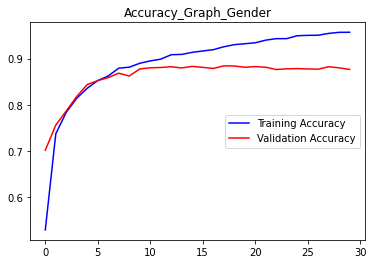

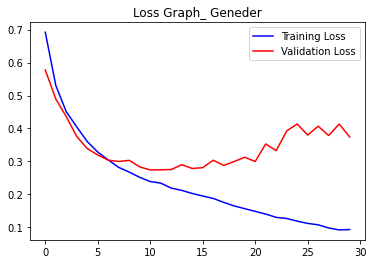

In [ ]:
# plot results for gender

acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy_Graph_Gender')
plt.legend(loc='right')
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph_ Geneder')
plt.legend()
plt.show()


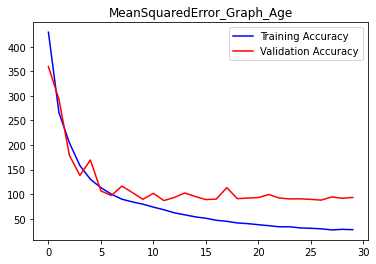

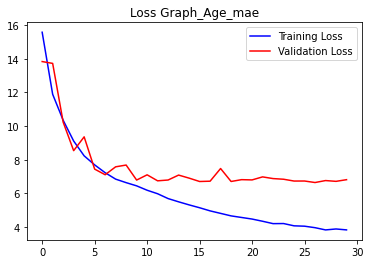

In [ ]:


# plot results for age


acc = history.history['age_out_mse']
val_acc = history.history['val_age_out_mse']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('MeanSquaredError_Graph_Age')
plt.legend()
plt.figure()


loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph_Age_mae')
plt.legend()
plt.show()



In [ ]:
# save and load the model 
#model.save('/content/drive/MyDrive/DL_Comp263_section2_Gr1/Code/model/model2.h5')
#model1=tf.keras.models.load_model('/content/drive/MyDrive/DL_Comp263_section2_Gr1/Code/model/model2.h5')
#model1.evaluate(X_test, [y_test_gender, y_test_age])

In [ ]:
print('Validation MSE for age: ',history.history['val_age_out_mse'][19])
print('Validation accuracy for gender: ',history.history['val_gender_out_accuracy'][19])

Validation MSE for age:  92.13713836669922
Validation accuracy for gender:  0.8811280727386475


Evaluate the test data 

In [ ]:
#model.evaluate(X_test, [y_test_gender, y_test_age])

In [ ]:
test_loss,test_gender_out_loss,  test_age_out_loss, test_gender_out_accuracy, test_gender_out_mse, test_age_out_accuracy,test_age_out_mse =model.evaluate(X_test, [y_test_gender, y_test_age])

149/149 [==============================] - 1s 7ms/step - loss: 7.0661 - gender_out_loss: 0.3667 - age_out_loss: 6.6994 - gender_out_accuracy: 0.8855 - gender_out_mse: 0.0884 - age_out_accuracy: 0.0055 - age_out_mse: 89.7960


In [ ]:
print('MeanSquaredError for age test data:',test_age_out_mse )
print('Accuracy for gender test data:     ',test_gender_out_accuracy)


MeanSquaredError for age test data: 89.79600524902344
Accuracy for gender test data:      0.8854913711547852


Print R2 score for regression problem

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
pred=model.predict(X_test)

In [ ]:
rounded =[ np.round(x) for x in pred[1]]
print(rounded)

[array([77.], dtype=float32), array([25.], dtype=float32), array([31.], dtype=float32), array([49.], dtype=float32), array([39.], dtype=float32), array([43.], dtype=float32), array([25.], dtype=float32), array([37.], dtype=float32), array([0.], dtype=float32), array([27.], dtype=float32), array([12.], dtype=float32), array([0.], dtype=float32), array([26.], dtype=float32), array([30.], dtype=float32), array([42.], dtype=float32), array([40.], dtype=float32), array([30.], dtype=float32), array([41.], dtype=float32), array([34.], dtype=float32), array([40.], dtype=float32), array([51.], dtype=float32), array([38.], dtype=float32), array([30.], dtype=float32), array([0.], dtype=float32), array([50.], dtype=float32), array([11.], dtype=float32), array([20.], dtype=float32), array([26.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([53.], dtype=float32), array([63.], dtype=float32), array([46.], dtype=float32), array([24.], dtype

In [ ]:
rounded=np.array(rounded)

In [ ]:
rounded=rounded.reshape(-1)

In [ ]:
print('R2 Score for age test data:',r2_score(y_test_age, rounded))

R2 Score for age test data: 0.7753640937388485


# 7. Prediction with Test Data

Original Gender: Female Original Age: 24
Predicted Gender: Female Predicted Age: 25


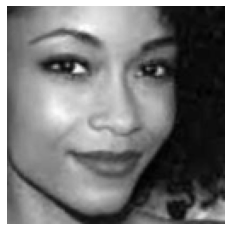

In [ ]:
image_index = 1
print("Original Gender:", gender_dict[y_test_gender[image_index]], "Original Age:", y_test_age[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 20
Predicted Gender: Female Predicted Age: 23


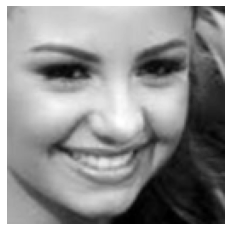

In [ ]:


image_index = 200
print("Original Gender:", gender_dict[y_test_gender[image_index]], "Original Age:", y_test_age[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128),cmap='gray');



Original Gender: Female , Original Age: 65
Predicted Gender: Female , Predicted Age: 52


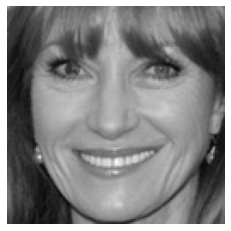

In [ ]:


image_index = 3050
print("Original Gender:", gender_dict[y_test_gender[image_index]], ", Original Age:", y_test_age[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, ", Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128),cmap='gray');



Original Gender: Female , Original Age: 23
Predicted Gender: Female , Predicted Age: 23


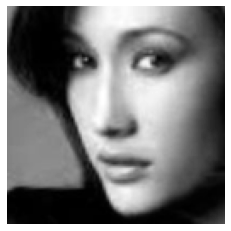

In [ ]:

image_index = 4000
print("Original Gender:", gender_dict[y_test_gender[image_index]], ", Original Age:", y_test_age[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, ", Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128),cmap='gray');


Original Gender: Male , Original Age: 26
Predicted Gender: Male , Predicted Age: 29


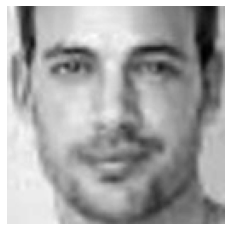

In [ ]:

image_index = 277
print("Original Gender:", gender_dict[y_test_gender[image_index]], ", Original Age:", y_test_age[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, ", Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128),cmap='gray');

Original Gender: Female , Original Age: 51
Predicted Gender: Female , Predicted Age: 41


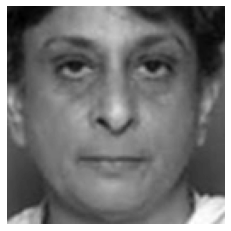

In [ ]:
image_index = 17
print("Original Gender:", gender_dict[y_test_gender[image_index]], ", Original Age:", y_test_age[image_index])
# predict from model
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, ", Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index].reshape(128, 128),cmap='gray');